<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')

### Validation 0: Initial Analysis of Features

In [3]:
## Initial Analysis.
## - Data range is from 2008 to 2010. (based on Year Sold Field)

print('Year Sold Values:',house.YrSold.unique())
print('Rows, Columns: ',house.shape)

Year Sold Values: [2008 2007 2006 2009 2010]
Rows, Columns:  (1460, 81)


In [4]:
print(house.columns)

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [5]:
house.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


### Validation 1: Remove non-residential houses

In [6]:
## Remove non-residential houses
## - RL,RM,RH, & FV are residential.
## - Remove C (COMMERCIAL) (10 rows will be removed)

house=house[house['MSZoning'] != 'C (all)']

In [7]:
## Confirm that 10 rows were removed.
print(house.shape)

house.groupby('MSZoning').size()

(1450, 81)


MSZoning
FV      65
RH      16
RL    1151
RM     218
dtype: int64

### Validation 2: Cleaning of Null Values

In [8]:
## Search for features with null values
print('LIST OF COLUMNS WITH POTENTIAL NULL VALUES')
null_list=house.isnull().sum().sort_values(ascending=False)
null_list[null_list>0]

LIST OF COLUMNS WITH POTENTIAL NULL VALUES


PoolQC          1443
MiscFeature     1398
Alley           1361
Fence           1172
FireplaceQu      681
LotFrontage      259
GarageCond        79
GarageType        79
GarageYrBlt       79
GarageFinish      79
GarageQual        79
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

In [9]:
## columns that have null values:
cols=['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage', 'GarageCond',  
      'GarageType',  'GarageYrBlt', 'GarageFinish','GarageQual',  'BsmtExposure','BsmtFinType2',
      'BsmtFinType1','BsmtCond','BsmtQual', 'MasVnrArea',  'MasVnrType','Electrical' ]

df=house[cols]
      
#print(df.columns)
print('Columns that are continuous (to be updated with median value)')
print('-------------------')
print(df.describe())

Columns that are continuous (to be updated with median value)
-------------------
       LotFrontage  GarageYrBlt   MasVnrArea
count  1191.000000  1371.000000  1442.000000
mean     70.052897  1978.627279   104.404300
std      24.301013    24.592779   181.486539
min      21.000000  1906.000000     0.000000
25%      59.000000  1961.500000     0.000000
50%      70.000000  1980.000000     0.000000
75%      80.000000  2002.000000   166.750000
max     313.000000  2010.000000  1600.000000


In [10]:
## Among our list of fields with null values, 
## 3 fields will be replaced with thier median
##   ('LotFrontage','GarageYrBlt','MasVnrArea')

In [11]:
## This will list the values of categorical fields with null values
## This will be used for analysis on what value might be used to be replaced null values

continuous_list = ['LotFrontage','GarageYrBlt','MasVnrArea']

print('Evaluate existing values of Categorical Fields:')
for col in cols:
    if col not in continuous_list :
        print('-------------------------')
        print(col,':',df[col].unique())
        print(df[df[col].isnull()==False].groupby(col).size())

Evaluate existing values of Categorical Fields:
-------------------------
PoolQC : [nan 'Ex' 'Fa' 'Gd']
PoolQC
Ex    2
Fa    2
Gd    3
dtype: int64
-------------------------
MiscFeature : [nan 'Shed' 'Gar2' 'Othr' 'TenC']
MiscFeature
Gar2     2
Othr     2
Shed    47
TenC     1
dtype: int64
-------------------------
Alley : [nan 'Grvl' 'Pave']
Alley
Grvl    50
Pave    39
dtype: int64
-------------------------
Fence : [nan 'MnPrv' 'GdWo' 'GdPrv' 'MnWw']
Fence
GdPrv     59
GdWo      53
MnPrv    155
MnWw      11
dtype: int64
-------------------------
FireplaceQu : [nan 'TA' 'Gd' 'Fa' 'Ex' 'Po']
FireplaceQu
Ex     24
Fa     33
Gd    379
Po     20
TA    313
dtype: int64
-------------------------
GarageCond : ['TA' nan 'Gd' 'Fa' 'Po' 'Ex']
GarageCond
Ex       2
Fa      34
Gd       9
Po       7
TA    1319
dtype: int64
-------------------------
GarageType : ['Attchd' 'Detchd' 'BuiltIn' 'CarPort' nan 'Basment' '2Types']
GarageType
2Types       6
Attchd     870
Basment     18
BuiltIn     88
CarPo

**Findings on Fields with null values:**

In [12]:
## FINDINGS(null values):

## 'LotFrontage','GarageYrBlt','MasVnrArea' are continuous fields
##  - use median to replace null values.

## Other Fields are categorical and will be the following updates will be made:

## a) Replace Null values with NA (this is based on field description in data_description.txt)
##       BsmtQual BsmtCond BsmtFinType1 BsmtFinType2 BsmtExposure 
##       GarageQual GarageFinish GarageType GarageCond
##       FireplaceQu Alley MiscFeature PoolQC Fence

## b) Replace Null values with None (this is based on field description in data_description.txt)
##      MasVnrType 

## c) Electrical - will replace with the mode.
##       

#### **Update Null Values:**

In [13]:
# LotFrontage (Use the the median to replace null values)
col='LotFrontage'

print('({}) number of null values Before Update: '.format(col),house[col].isnull().sum())
house[col] = house[col].fillna((df[col].median()))
print('({}) number of null values After  Update: '.format(col),house[col].isnull().sum())

(LotFrontage) number of null values Before Update:  259
(LotFrontage) number of null values After  Update:  0


In [14]:
# Alley (Replace Null values with NA)
col='Alley'

print('({}) number of null values Before Update: '\
      .format(col),house[col].isnull().sum())
house[col] = house[col].fillna(('NA'))
print('({}) number of null values After  Update: '\
      .format(col),house[col].isnull().sum())

(Alley) number of null values Before Update:  1361
(Alley) number of null values After  Update:  0


In [15]:
# Basement (Replace Null values with NA)
cols=['BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2', 'BsmtExposure']

for col in cols:
    print('({}) number of null values Before Update: '.format(col),house[col].isnull().sum())
    house[col] = house[col].fillna(('NA'))
    print('({}) number of null values After  Update: '.format(col),house[col].isnull().sum())
    print('--------------------------------')

(BsmtQual) number of null values Before Update:  37
(BsmtQual) number of null values After  Update:  0
--------------------------------
(BsmtCond) number of null values Before Update:  37
(BsmtCond) number of null values After  Update:  0
--------------------------------
(BsmtFinType1) number of null values Before Update:  37
(BsmtFinType1) number of null values After  Update:  0
--------------------------------
(BsmtFinType2) number of null values Before Update:  38
(BsmtFinType2) number of null values After  Update:  0
--------------------------------
(BsmtExposure) number of null values Before Update:  38
(BsmtExposure) number of null values After  Update:  0
--------------------------------


In [16]:
# Garage (Replace Null values with NA)
cols=['GarageQual', 'GarageFinish', 'GarageType', 'GarageCond', ]

for col in cols:
    print('({}) number of null values Before Update: '.format(col),house[col].isnull().sum())
    house[col] = house[col].fillna(('NA'))
    print('({}) number of null values After  Update: '.format(col),house[col].isnull().sum())
    print('--------------------------------')

(GarageQual) number of null values Before Update:  79
(GarageQual) number of null values After  Update:  0
--------------------------------
(GarageFinish) number of null values Before Update:  79
(GarageFinish) number of null values After  Update:  0
--------------------------------
(GarageType) number of null values Before Update:  79
(GarageType) number of null values After  Update:  0
--------------------------------
(GarageCond) number of null values Before Update:  79
(GarageCond) number of null values After  Update:  0
--------------------------------


In [17]:
# Garage Year that was built (Replace Null values with 0)
col='GarageYrBlt'
print('({}) number of null values Before Update: '.format(col),house[col].isnull().sum())
house[col] = house[col].fillna((0))
print('({}) number of null values After  Update: '.format(col),house[col].isnull().sum())

(GarageYrBlt) number of null values Before Update:  79
(GarageYrBlt) number of null values After  Update:  0


In [18]:
# Fireplace (Replace Null values with NA)
col='FireplaceQu'

print('({}) number of null values Before Update: '.format(col),house[col].isnull().sum())
house[col] = house[col].fillna(('NA'))
print('({}) number of null values After  Update: '.format(col),house[col].isnull().sum())

(FireplaceQu) number of null values Before Update:  681
(FireplaceQu) number of null values After  Update:  0


In [19]:
# Miscellaneous (Replace Null values with NA)
col='MiscFeature'

print('({}) number of null values Before Update: '.format(col),house[col].isnull().sum())
house[col] = house[col].fillna(('NA'))
print('({}) number of null values After  Update: '.format(col),house[col].isnull().sum())

(MiscFeature) number of null values Before Update:  1398
(MiscFeature) number of null values After  Update:  0


In [20]:
# Masonry (Replace Null values with None)
col='MasVnrType'

print('({}) number of null values Before Update: '.format(col),house[col].isnull().sum())
house[col] = house[col].fillna(('None'))
print('({}) number of null values After  Update: '.format(col),house[col].isnull().sum())

(MasVnrType) number of null values Before Update:  8
(MasVnrType) number of null values After  Update:  0


In [21]:
# Masonry veneer area in square feet (Replace Null values with median)
col='MasVnrArea'

print('({}) number of null values Before Update: '.format(col),house[col].isnull().sum())
house[col] = house[col].fillna((house[col].median()))
print('({}) number of null values After  Update: '.format(col),house[col].isnull().sum())

(MasVnrArea) number of null values Before Update:  8
(MasVnrArea) number of null values After  Update:  0


In [22]:
# Pool Quality (Replace Null values with NA [No Pool])
col='PoolQC'

print('({}) number of null values Before Update: '.format(col),house[col].isnull().sum())
house[col] = house[col].fillna(('NA'))
print('({}) number of null values After  Update: '.format(col),house[col].isnull().sum())

(PoolQC) number of null values Before Update:  1443
(PoolQC) number of null values After  Update:  0


In [23]:
# Fence Quality (Replace Null values with NA [No Fence])
col='Fence'

print('({}) number of null values Before Update: '.format(col),house[col].isnull().sum())
house[col] = house[col].fillna(('NA'))
print('({}) number of null values After  Update: '.format(col),house[col].isnull().sum())

(Fence) number of null values Before Update:  1172
(Fence) number of null values After  Update:  0


In [24]:
# Electrical (Replace Null values with the 'SBrkr') 
col='Electrical'

print('({}) number of null values Before Update: '.format(col),house[col].isnull().sum())
house[col] = house[col].fillna((house[col].mode()[0]))
print('({}) number of null values After  Update: '.format(col),house[col].isnull().sum())

(Electrical) number of null values Before Update:  1
(Electrical) number of null values After  Update:  0


In [25]:
print(house.isnull().sum().sort_values(ascending=False).head(19))

SalePrice       0
Heating         0
RoofStyle       0
RoofMatl        0
Exterior1st     0
Exterior2nd     0
MasVnrType      0
MasVnrArea      0
ExterQual       0
ExterCond       0
Foundation      0
BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinSF1      0
BsmtFinType2    0
BsmtFinSF2      0
BsmtUnfSF       0
dtype: int64


In [26]:
## No more columns with null values are found in the data.

### EDA Analysis

In [27]:
print(house.SalePrice.describe())
print()
print('median:',house.SalePrice.median())

count      1450.000000
mean     181654.942069
std       79176.485241
min       37900.000000
25%      130000.000000
50%      163945.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

median: 163945.0


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


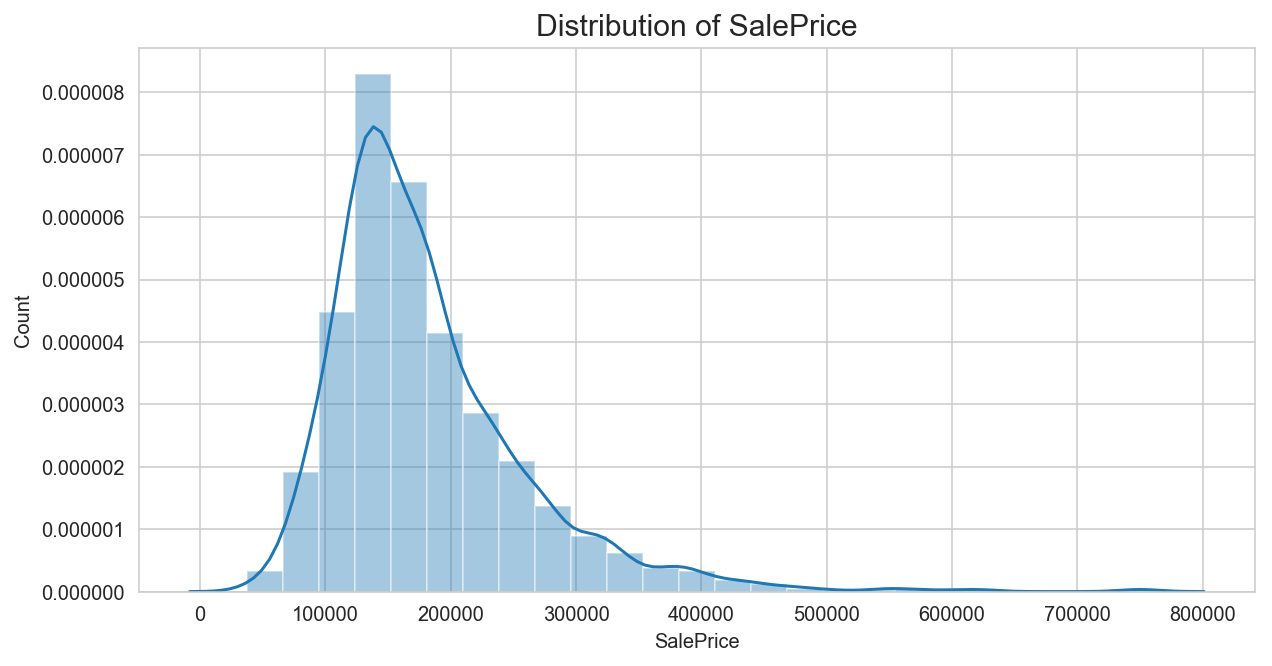

In [28]:
plt.figure(figsize=(10,5))
#sns.distplot(house['SalePrice'], bins=30, kde=False)
sns.distplot(house['SalePrice'], bins=25)
plt.title('Distribution of SalePrice',fontsize = 15)
plt.ylabel('Count')
plt.show()

In [29]:
# The SalesPrice is positively skewed (mean is greater than median)

### Feature Variables Changes

### 1. Id Column
- `Id` Column is dropped because it does not contribute to the prediction of the model.

In [30]:
## Remove Id form dataset
house = house.drop('Id', axis =1)

**2. GrLivArea (Above grade (ground) living area square feet)**
 - `GrLivArea` column is sum of **1stFlrSF**, **2ndFlrSF**, and **LowQualFinSF**.
 - `1stFlrSF`, `2ndFlrSF`, and `LowQualFinSF` will be dropped coz no longer needed

In [31]:
## Validation: Check if GrLivArea is the sum of 1stFlrSF, 2ndFlrSF & LowQualFinSF
mycol = ['1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea']
df2=house[mycol]

total = df2.values[:,0:3].astype(int).sum(axis=1)
df2.loc[:,'Total']= total

print('Rows where sum(1stFlrSF,2ndFlrSF,LowQualFinSF) != GrLivArea:',len(df2[df2['GrLivArea']!=df2['Total']]))

Rows where sum(1stFlrSF,2ndFlrSF,LowQualFinSF) != GrLivArea: 0


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [32]:
## GrLivArea (Above grade ground living area square feet) is the sum of the
##    1st & 2nd floor & low Quality Finished square feet (1stFlrSF & 2ndFlrSF & LowQualFinSF).   
##    drop 1stFlrSF & 2ndFlrSF & LowQualFinSF

mycol=['1stFlrSF', '2ndFlrSF', 'LowQualFinSF']
house=house.drop(mycol, axis=1)

**3. TotalBSmtSF (Total square feet of basement area)**
 - `TotalBSmtSF` column is sum of BsmtFinSF1, BsmtFinSF2, and BsmtUnfSF.
 - `BsmtFinSF1`, `BsmtFinSF2`, and `BsmtUnfSF` will be dropped coz no longer needed

In [33]:
## Validation: Confirm if TotalBsmtSF = BsmtFinSF1 + BsmtFinSF2 + BsmtUnfSF

mycol = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']
df2=house[mycol]

total=df2.values[:,0:3].astype(int).sum(axis=1)
df2.loc[:,'Total']=total

print('Rows where sum(BsmtFinSF1,BsmtFinSF2,BsmtUnfSF) != TotalBsmtSF:',len(df2[df2['TotalBsmtSF']!=df2['Total']]))

Rows where sum(BsmtFinSF1,BsmtFinSF2,BsmtUnfSF) != TotalBsmtSF: 0


In [34]:
## We have confirmed that TotalBsmtSF (Total square feet of basement area) is the sum of the
##    (BsmtFinSF1 + BsmtFinSF2 + BsmtUnfSF).   We can drop these 3 fields

mycol = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF']
house=house.drop(mycol, axis=1)

**4. New Column Bathrooms** 
 - `Bathrooms` is the sum of BsmtFullBath + BsmtHalfBath + FullBath + HalfBath
 - Values of `HalfBath` & `BsmtHalfBath` are divided in half before aggregation. 
 - `BsmtFullBath`, `FullBath`, `BsmtHalfBath`, `HalfBath` will be dropped.

In [35]:
## New Column 'Bathrooms'.  This is the sum of FullBath, BsmtFullBath, HalfBath & BsmtHalfBath.
##   Values of HalfBath & BsmtHalfBath are divided in half 
##     e.g. Bathrooms = 1.5 (FullBath=1 & HalfBath=.5 & BsmtFullBath=0 & BsmtHalfBath=0)

house.loc[:,'BsmtHalfBath'] = house.BsmtHalfBath / 2
house.loc[:,'HalfBath']     = house.HalfBath / 2

house.loc[:,'Bathrooms'] = house.FullBath + house.BsmtFullBath +  \
                           house.HalfBath + house.BsmtHalfBath  

In [36]:
mycol = ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'Bathrooms']
house[mycol].head(3)

,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,Bathrooms
0,1,0.0,2,0.5,3.5
1,0,0.5,2,0.0,2.5
2,1,0.0,2,0.5,3.5


In [37]:
## We can drop FullBath, BsmtFullBath, HalfBath & BsmtHalfBath
cols=['BsmtFullBath', 'BsmtHalfBath', 'FullBath','HalfBath']
house = house.drop(cols, axis =1)

**5. New Column TotalSqft** 
 - `TotalSqft` is the sum of TotalBSmtSF + Bathrooms + GarageArea

In [38]:
# create a column for total sqft
house['TotalSqft'] = house['TotalBsmtSF'] + house['GarageArea'] + house['GrLivArea'] 

#### Fixed & Renovate Columns 

In [39]:
## fixed columns
fixed =['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'YearBuilt',
       'MasVnrArea', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'GrLivArea', 'BedroomAbvGr', 
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Functional', 
       'Fireplaces', 'GarageType', 'GarageYrBlt', 'GarageArea',
       'PavedDrive', 'Fence', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition', 'Bathrooms', 'TotalSqft', 'SalePrice']       

## renovate columns
reno =['OverallQual', 'OverallCond', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Heating', 'HeatingQC', 'CentralAir', 
       'Electrical', 'KitchenQual', 'FireplaceQu',
       'GarageFinish', 'GarageQual', 'GarageCond',  'Fence', 'MiscVal' ]

In [40]:
## categorical columns (extracted from fixed)
categorical=['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour', 
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 
       'BldgType', 'HouseStyle','Foundation', 'BsmtQual', 'BsmtCond', 
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Functional', 
       'GarageType', 'PavedDrive', 'Fence', 'SaleType', 'SaleCondition']

## numerical columns (subjective)
numerical=['LotFrontage', 'LotArea', 'YearBuilt', 'MasVnrArea', 'GrLivArea',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageArea', 'MoSold', 'YrSold', 'SalePrice']

## numerical columns (extracted from fixed)
numerical=[x for x in fixed if x not in categorical]

## Splitting the dataset

#### Create Dummies

In [41]:
## Extract Fixed Columns
df=house[fixed]  
print('Fixed:',df.shape)

## get dummy from categorical
df_dummy=pd.get_dummies(df, columns=categorical, drop_first=True)
print('Dummy:',df_dummy.shape)

df2=df_dummy


Fixed: (1450, 40)
Dummy: (1450, 156)


#### Split train & test

In [42]:
# split data to train and test, pre/post 2010
test = df2[df2['YrSold'] == 2010]
train = df2[df2['YrSold'] < 2010]

print(' train shape:',train.shape,'\n', 'test shape :', test.shape, '\n')

X_train = train.iloc[:, train.columns != 'SalePrice'] 
y_train = train['SalePrice']

X_test = test.iloc[:, test.columns != 'SalePrice']
y_test = test['SalePrice']

print(' X_train shape:', X_train.shape, '\n', 'y_train shape:', y_train.shape, '\n')
print(' X_test shape :', X_test.shape, '\n',  'y_test shape :', y_test.shape)


 train shape: (1278, 156) 
 test shape : (172, 156) 

 X_train shape: (1278, 155) 
 y_train shape: (1278,) 

 X_test shape : (172, 155) 
 y_test shape : (172,)


#### Initialize StandardScaler

In [43]:
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn import metrics
import statsmodels.api as sm

In [44]:
# scale data
ss = StandardScaler()
#ss.fit(X_train)

# Transform train and test
#Xs_train = ss.transform(X_train)
#Xs_test = ss.transform(X_test)

Xs_train = ss.fit_transform(X_train)
Xs_test=ss.transform(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  # Remove the CWD from sys.path while we load stuff.


## Regression Models

##### 1. Linear Regression Model

In [45]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score

linear = LinearRegression()
linear_scores = cross_val_score(linear, Xs_train, y_train, cv=10)

print('score: \n',linear_scores,'\n')
print('score(mean):',np.mean(linear_scores))

score: 
 [ 8.84887397e-01  8.07726553e-01 -2.13116869e+22 -5.75267126e+21
 -8.55967430e+14 -2.15327013e+22 -2.86075677e+23  7.89661372e-01
 -1.37430266e+17  8.23241296e-01] 

score(mean): -3.346728746321569e+22


##### 2. Ridge Regression Model

In [46]:
## Extract best alpha
alpha_range = np.logspace(-2, 7, 50)

# select the best alpha with RidgeCV
optimal_ridge = RidgeCV(alphas=alpha_range, cv=10)
optimal_ridge.fit(X_train, y_train)

print('Best alpha: {}'.format(optimal_ridge.alpha_))

Best alpha: 8.685113737513529


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [47]:
ridge = Ridge(alpha=optimal_ridge.alpha_)

ridge_scores = cross_val_score(ridge, Xs_train, y_train, cv=10)

print('score: \n',ridge_scores,'\n')
print('score(mean):',np.mean(ridge_scores))


score: 
 [0.89551346 0.8158367  0.85334484 0.71689148 0.85375692 0.68793768
 0.86531611 0.80484449 0.56011744 0.83118502] 

score(mean): 0.7884744137796004


##### 3. Lasso Regression Model

In [48]:
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(Xs_train, y_train)

#print(optimal_lasso.alpha_)
print('Best alpha: {}'.format(optimal_lasso.alpha_))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Best alpha: 891.7211643201987


......................................................................................[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.1s finished


In [49]:
lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_scores = cross_val_score(lasso, Xs_train, y_train, cv=10)

print('score: \n',lasso_scores,'\n')
print('score(mean):',np.mean(lasso_scores))

score: 
 [0.90172856 0.84716228 0.86527654 0.74056654 0.83891608 0.73562222
 0.8928381  0.81898355 0.5232282  0.86028194] 

score(mean): 0.8024604005568298


##### 4. Compare Results (Linear  vs Ridge vs Lasso)

In [50]:
## Results scores are:

# a. Linear Regression  -1.4828622658219043e+23
# b. Ridge              0.7866910603455588
# c. Lasso              0.8031893200167444

## Lasso Model has the best score. So we will select Lasso Model
## to process coefficients for variables

## Identify Coefficients in Lasso Model

In [51]:
model_lasso=lasso.fit(Xs_train, y_train)

In [52]:
col_lasso=X_train.columns


lasso_coefs = pd.DataFrame({'variable':col_lasso,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs.head(20)

,variable,coef,abs_coef
4,GrLivArea,21767.754756,21767.754756
14,TotalSqft,14091.894818,14091.894818
60,Neighborhood_NridgHt,11371.579592,11371.579592
103,BsmtQual_TA,-11243.500518,11243.500518
101,BsmtQual_Gd,-11236.688831,11236.688831
59,Neighborhood_NoRidge,8588.078257,8588.078257
2,YearBuilt,7933.329546,7933.329546
66,Neighborhood_StoneBr,7021.300848,7021.300848
13,Bathrooms,6493.503072,6493.503072
6,KitchenAbvGr,-5702.265409,5702.265409


In [53]:
print('Percent variables zeroed out:', np.sum((lasso.coef_ == 0))/float(len(lasso.coef_)),'\n')
print(model_lasso)

Percent variables zeroed out: 0.5419354838709678 

Lasso(alpha=891.7211643201987, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)


In [54]:
#calculating the predicted value
predictions_mod1=model_lasso.predict(Xs_test)

#residual calculation
Residuals_mod1=y_test-predictions_mod1

X_test['Residuals']  = Residuals_mod1
X_test['predictions']= predictions_mod1
X_test['y_test']     = y_test

In [55]:
X_test.head()

,LotFrontage,LotArea,YearBuilt,MasVnrArea,GrLivArea,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,...,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Residuals,predictions,y_test
16,70.0,11241,1970,180.0,1004,2,1,5,1,1970.0,...,0,1,0,0,0,1,0,-2791.966072,151791.966072,149000
24,70.0,8246,1968,0.0,1060,3,1,6,1,1968.0,...,0,1,0,0,0,1,0,9968.762218,144031.237782,154000
26,60.0,7200,1951,0.0,900,3,1,5,0,2005.0,...,0,1,0,0,0,1,0,10555.213100,124244.786900,134800
27,98.0,11478,2007,200.0,1704,3,1,7,1,2008.0,...,0,1,0,0,0,1,0,-1263.326008,307263.326008,306000
33,70.0,10552,1959,0.0,1700,4,1,6,1,1959.0,...,0,1,0,0,0,1,0,-13579.316047,179079.316047,165500


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


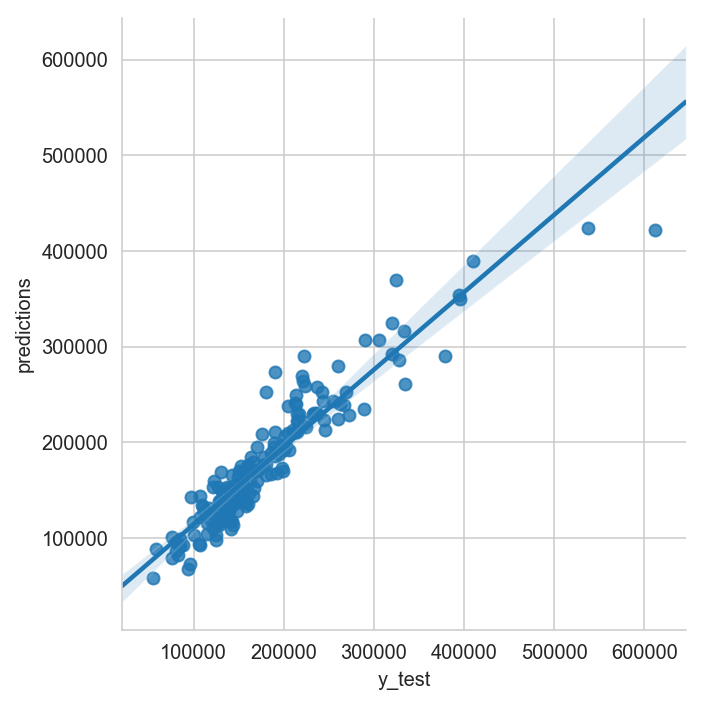

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.lmplot(x='y_test', y='predictions', data=X_test)

In [57]:
#the actual and predicted values has linear relationship. 
#it shows that our model well fitted. 

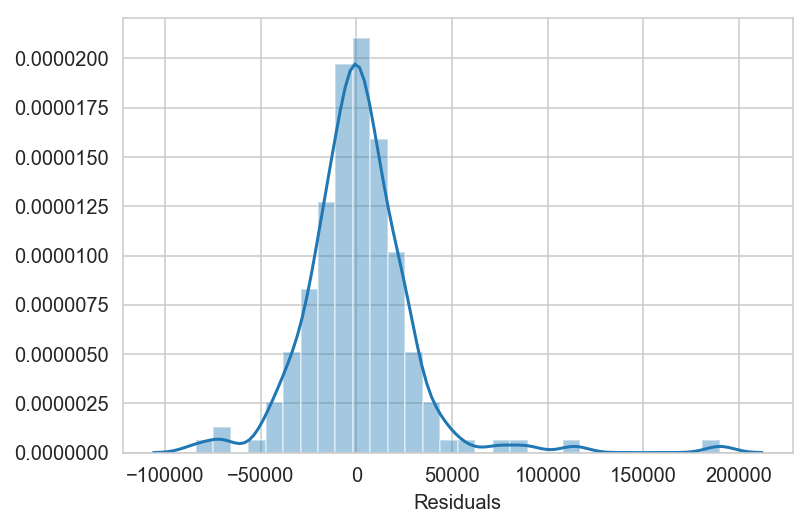

In [58]:
sns.distplot(X_test['Residuals'])

In [59]:
# The errors are more or less skewed to the right, but do show approximate normality otherwise.

### Summary (Question 1): 

1. **Validation on Data**
    1. Non-residential houses were removed.
    2. All Features with Null Values were cleaned in data
    3. EDA Analaysis was performed on target feature `SalePrice`
2. **Feature Engineering was performed**
    1. Id Column was removed
    2. **Drop** 1stFlrSF, 2ndFlrSF, and LowQualFinSF because
          these fields are the sum of `GrLivArea`.
    3. **Drop** BsmtFinSF1, BsmtFinSF2, and BsmtUnfSF because
          these fields are the sum of `TotalBSmtSF`
    4. **Create** new feature Bathrooms which is the sum of 
    BsmtFullBath + BsmtHalfBath + FullBath + HalfBath
    5. **Drop** BsmtFullBath, BsmtHalfBath, FullBath & HalfBath. 
    6. **Create** new feature `TotalSqft` which is the sum of
    TotalBSmtSF + Bathrooms + GarageArea
3. **Create Models and Compare Scores**    
    1. Data used only created fixed features.
    2. Linear Regression, Ridge & Lasso Models were used on the data.  All Models were trained using pre-2010 data.
    3. Compared all three models and Lasso & Ridge Model scored better than Linear Regression.analysis.
    4. Lasso Model was used for further analysis.  Based on the model R2 value (0.8031), we can say that the predictor variables for the model could explain 80.3% of variance in the target variable(SalePrice)
    5. `GrLivArea` is the feature that could contribute most to the SalePrice. For 1 unit increase in GrLivArea the SalePrice could increase by 21,767
    6. The second important feature id is `TotalSqft`, which is the sum of TotalBSmtSF, Bathrooms, & GarageArea.  For 1 unit increase in TotalSqft the SalePrice could increase by 14,091
    7. The Basement Quality which corresponds to the height of the basement is the most important factor which accounts for the decrease in the house price. The BaseQuality which is Good and Typical shows decrease of SalePrice about 11,2236 to 11,243.
    

          


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [60]:
## renovate columns (For reference only...)
reno =['OverallQual', 'OverallCond', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Heating', 'HeatingQC', 'CentralAir', 
       'Electrical', 'KitchenQual', 'FireplaceQu',
       'GarageFinish', 'GarageQual', 'GarageCond',  'Fence', 'MiscVal' ]


In [61]:
## list fields to be dummyfied.
dummy_cols=['MSSubClass', 'MSZoning','Street','LotShape','LandContour',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle','Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Functional',
       'GarageType','PavedDrive', 'Fence', 
       'SaleType', 'SaleCondition','OverallQual', 'OverallCond','RoofStyle', 
       'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'ExterQual', 'ExterCond','Heating','HeatingQC', 
       'CentralAir', 'Electrical', 
       'KitchenQual','FireplaceQu','GarageQual','GarageFinish', 'GarageCond',
       'Fence']

In [62]:
house_dummy= pd.get_dummies(house,columns=dummy_cols,drop_first=True)
print(house_dummy.shape)
#house_dummy.head(3)

(1450, 277)


In [63]:
## Remove these categorical features
drop_list=['Alley', 'Utilities','PoolQC','MiscFeature']
house_dummy.drop(drop_list, axis=1, inplace=True)

In [64]:
house.YrSold.unique()
house[house['YrSold']==2009].head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Bathrooms,TotalSqft
5,50,RL,85.0,14115,Pave,NA,IR1,Lvl,AllPub,Inside,...,MnPrv,Shed,700,10,2009,WD,Normal,143000,2.5,2638
7,60,RL,70.0,10382,Pave,NA,IR1,Lvl,AllPub,Corner,...,NA,Shed,350,11,2009,WD,Normal,200000,3.5,3681
19,20,RL,70.0,7560,Pave,NA,Reg,Lvl,AllPub,Inside,...,MnPrv,NA,0,5,2009,COD,Abnorml,139000,1.0,2662


In [65]:
#Train data with data from yrSold 2006,2007 and 2008. 
#Test data is with data from YrSold 2010

df2=house_dummy
X_full=df2.iloc[:, df2.columns != 'SalePrice']

X_train_2=X_full[X_full['YrSold'] < 2010]
X_test_2 =X_full[X_full['YrSold'] == 2010]

y_train_2=house['SalePrice'][house['YrSold'] < 2010]
y_test_2=house['SalePrice'][house['YrSold'] == 2010]

print(' X_train_2 shape:', X_train_2.shape, '\n', 'y_train_2 shape:', y_train_2.shape, '\n')
print(' X_test_2 shape :', X_test_2.shape, '\n',  'y_test_2 shape :', y_test_2.shape )

 X_train_2 shape: (1278, 272) 
 y_train_2 shape: (1278,) 

 X_test_2 shape : (172, 272) 
 y_test_2 shape : (172,)


In [66]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score


ss = StandardScaler()
Xs_train_2 = ss.fit_transform(X_train_2)
Xs_test_2=ss.transform(X_test_2)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  


##### 1. Extract Best Alpha Values:

In [67]:
## Extract best alpha
alpha_range = np.logspace(-2, 7, 50)

# select the best alpha with RidgeCV
optimal_ridge = RidgeCV(alphas=alpha_range, cv=10)
optimal_ridge.fit(Xs_train_2, y_train_2)

print('Best alpha(Ridge): {}'.format(optimal_ridge.alpha_))

Best alpha(Ridge): 596.3623316594649


In [68]:
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(Xs_train_2, y_train_2)

#print(optimal_lasso.alpha_)
print('Best alpha(Lasso): {}'.format(optimal_lasso.alpha_))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Best alpha(Lasso): 1097.5123985130283


In [69]:
print('Linear Regression (5 Folds) \n')
#print('Folds: 5 \n')

model=LinearRegression()
scores = cross_val_score(model, Xs_train_2, y_train_2, cv=5)
print("Cross-validated scores:\n", scores)
print("Mean CV R2:", np.mean(scores))
print('Std  CV R2:', np.std(scores))

Linear Regression (5 Folds) 

Cross-validated scores:
 [-9.59232310e+17 -7.40022251e+20 -1.27897025e+24 -4.70682495e+21
 -1.91997421e+24]
Mean CV R2: -6.408784529506023e+23
Std  CV R2: 8.085125360414878e+23


In [70]:
print('Ridge Regression (5 Folds) \n')
#print('Folds: 5 \n')

model=Ridge(alpha=optimal_ridge.alpha_)
scores = cross_val_score(model, Xs_train_2, y_train_2, cv=5)
print("Cross-validated scores:\n", scores)
print("Mean CV R2:", np.mean(scores))
print('Std  CV R2:', np.std(scores))

Ridge Regression (5 Folds) 

Cross-validated scores:
 [0.90398947 0.84425503 0.83511965 0.8823419  0.71564664]
Mean CV R2: 0.8362705381471723
Std  CV R2: 0.06530486205211429


In [71]:
print('Lasso Regression (5 Folds) \n')
#print('Folds: 5 \n')

model=Lasso(alpha=optimal_lasso.alpha_)
scores = cross_val_score(model, Xs_train_2, y_train_2, cv=5)
print("Cross-validated scores:\n", scores)
print("Mean CV R2:", np.mean(scores))
print('Std  CV R2:', np.std(scores))

Lasso Regression (5 Folds) 

Cross-validated scores:
 [0.91048577 0.83202196 0.8416152  0.88134885 0.7013128 ]
Mean CV R2: 0.8333569151454183
Std  CV R2: 0.07177425290699106


### Coefficient from lasso model

In [72]:
lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_scores = cross_val_score(lasso, Xs_train_2, y_train_2, cv=10)

print(lasso_scores)
print(np.mean(lasso_scores))

[0.90176062 0.91539424 0.89310994 0.75762868 0.8694962  0.779288
 0.90765038 0.86125664 0.59334789 0.88406475]
0.8362997342519704


In [73]:
col2_lasso=X_train_2.columns

model2_lasso=lasso.fit(Xs_train_2, y_train_2)

lasso_coefs_ = pd.DataFrame({'variable':col2_lasso,
                            'coef':(lasso.coef_),
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs_.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs_.head(20)

,variable,coef,abs_coef
6,GrLivArea,18243.015901,18243.015901
172,OverallQual_9,13345.935580,13345.935580
173,OverallQual_10,12581.681765,12581.681765
171,OverallQual_8,9159.366219,9159.366219
24,TotalSqft,8145.048571,8145.048571
12,GarageCars,6682.182514,6682.182514
23,Bathrooms,6344.479910,6344.479910
69,Neighborhood_NoRidge,6302.176238,6302.176238
70,Neighborhood_NridgHt,6150.274368,6150.274368
90,Condition2_PosN,-6143.843172,6143.843172


In [74]:
print('Percent variables zeroed out:', np.sum((lasso.coef_ == 0))/float(len(lasso.coef_)))

Percent variables zeroed out: 0.7095588235294118


In [75]:
predictions_mod2=model2_lasso.predict(Xs_test_2)

Residuals_mod2=y_test_2-predictions_mod2

In [76]:
X_test_2['predictions_mod2']=predictions_mod2
X_test_2['Residuals_mod2']=Residuals_mod2
X_test_2['y_test_2']=y_test_2

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

In [77]:
X_test_2[['predictions_mod2','Residuals_mod2','y_test_2']].head(3)

,predictions_mod2,Residuals_mod2,y_test_2
16,156080.273958,-7080.273958,149000
24,148390.370484,5609.629516,154000
26,140327.685451,-5527.685451,134800


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


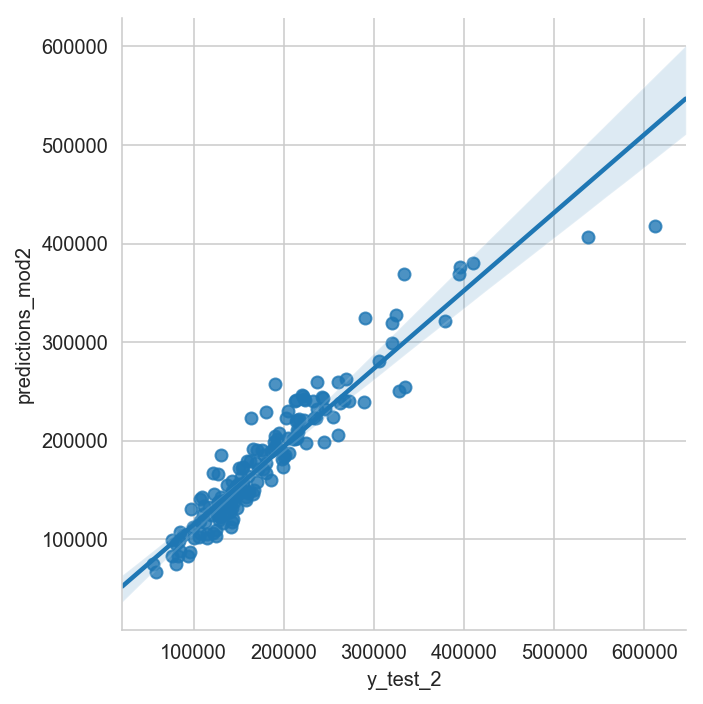

In [78]:
sns.lmplot(x='y_test_2', y='predictions_mod2', data=X_test_2) 
#there is linear relationship between test and predicted data.


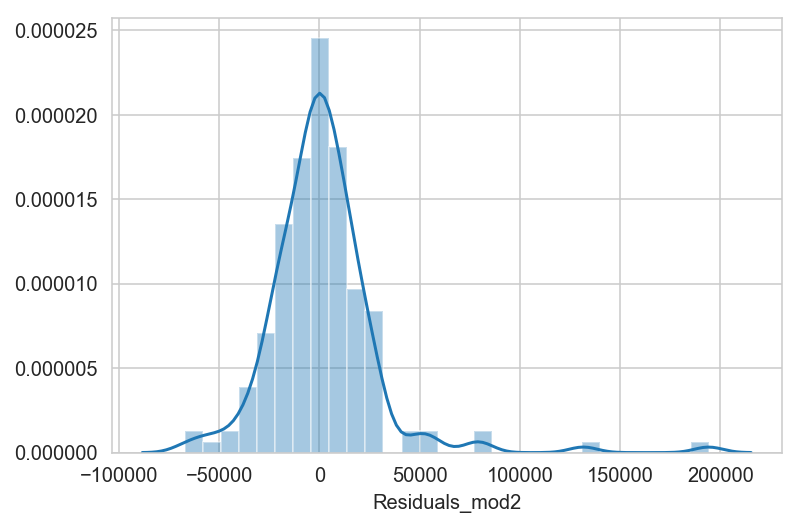

In [79]:
sns.distplot(X_test_2['Residuals_mod2']) 
# the residuals shows slight right skew.

### Summary (Question 2): 


1. **Create Models and Compare Scores**    
    1. Data used only created fixed features.
    2. Linear Regression, Ridge & Lasso Models were used on the data. 
    3. Compared all three models and Lasso & Ridge Model scored better than Linear Regression.analysis.
    4. Lasso Model was used for further analysis.  Based on the model R2 value (0.8362), we can say that the predictor variables for the model could explain 83.6% of variance in the target variable(SalePrice)
    5. `GrLivArea` is the feature that could contribute most to the SalePrice. For 1 unit increase in GrLivArea the SalePrice could increase by 18,243
    6. The second important feature id is The OverallQual which relates the overall material and finish of house could contribute most to the SalePrice. For every increase in overall quality (from Very good to Very excellent quality) there is about 9159 to 13345 increase in SalePrice. If the overall quality of the house increases the SalePrice also increases.
    7. The Basement Quality which corresponds to the height of the basement is the most important factor which accounts for the decrease in the house price. The BaseQuality which is Good and Typical shows decrease of SalePrice about 11,2236 to 11,243.
    8. From model 2, we can conclude that the renovatable features also important factors that influence SalePrice.  The most important renovatable features are Above grade (ground) living area square feet (a.k.a. GrLivArea), Overall Rating of materials and finish of the house, Roof Material, Remodel Year, and quality of materials in the exterior of the house.
    

          


<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [80]:
# A: I don't have to energy to answer #3...